In [1]:
%matplotlib inline
import twixtools
import numpy as np
import matplotlib.pyplot as plt
import os

example_dir = '../example_data'

def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

# 1) "low-level" access to your data

In [2]:
twix = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'))


try:
    # in case we have already run this once
    os.remove(os.path.join(example_dir, 'test.dat'))
except:
    pass

twixtools.write_twix(twix,os.path.join(example_dir, 'test.dat'))

twix2 = twixtools.read_twix(os.path.join(example_dir, 'test.dat'))


Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.


In [3]:
twix[0]['raidfile_hdr']

(286, 117512, 10240, 2510080, b'xxxxxxxxxxxxxxxxxxxx', b'gre_bc_2')

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
['Rep', 'Lin', 'Cha', 'Col']


(-0.5, 159.5, -0.5, 159.5)

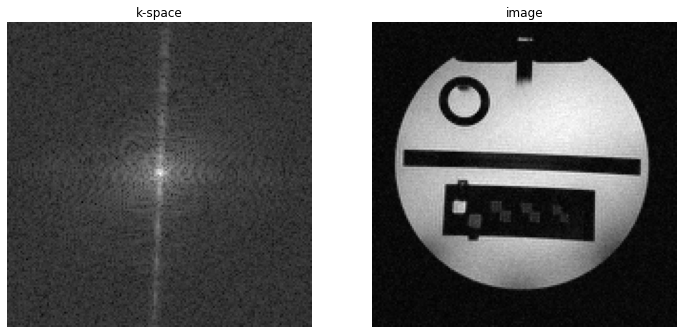

In [4]:
twix_singlechan = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'))
singlechan = twixtools.map_twix(twix_singlechan)
im_data = singlechan[-1]['image']
print(im_data.non_singleton_dims)
im_data.flags['remove_os'] = True
im_data.flags['average']['Rep'] = True
data = im_data[:].squeeze()

plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

image = ifftnd(data, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(abs(image), cmap='gray', origin='lower')
plt.axis('off')

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
('Ide', 'Idd', 'Idc', 'Idb', 'Ida', 'Seg', 'Set', 'Rep', 'Phs', 'Eco', 'Par', 'Sli', 'Ave', 'Lin', 'Cha', 'Col')
['Seg', 'Cha', 'Col']


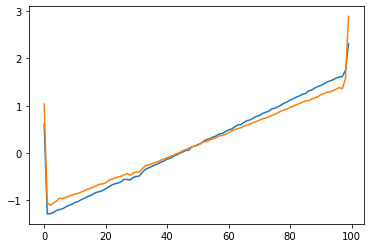

In [5]:
# read data and directly map to twix_array
epi_map = twixtools.map_twix(os.path.join(example_dir, 'epi.dat'))
pc_array = epi_map[-1]['phasecorr'].copy()

# set averaging flags
pc_array.flags['remove_os'] = True
pc_array.flags['average']['Lin']=True
pc_array.flags['average']['Par']=True

# print singleton_dims, to make sure that we select the correct data + shape
print(pc_array.dims)
print(pc_array.non_singleton_dims)

# phase difference in image space by complex multiplication (keeps magnitude for weighted average)
pc = ifftnd(pc_array[:])
pc = pc[:,:,:,:,:,[0]] * np.conj(pc[:,:,:,:,:,[1]])

# plot phase difference for all channels
plt.plot(np.angle(pc.squeeze()).T)

['Lin', 'Cha', 'Col']


(-0.5, 99.5, -0.5, 99.5)

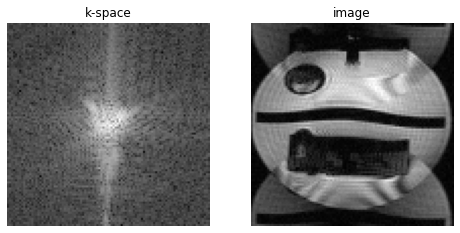

In [6]:
im_array = epi_map[-1]['image'].copy()

im_array.flags['remove_os'] = True
im_array.flags['average']['Seg'] = True
pc_array.flags['average']['Lin']=True
pc_array.flags['average']['Par']=True

print(im_array.non_singleton_dims)

data = im_array[:].squeeze()

plt.figure(figsize=[8,6])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

image = ifftnd(data, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

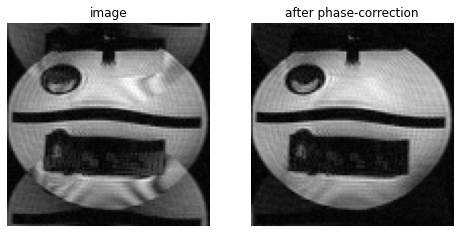

In [7]:
# for phase-correction, we need to keep the individual segments
im_array = epi_map[-1]['image'].copy()
im_array.flags['remove_os'] = True

pc_array = epi_map[-1]['phasecorr'].copy()
pc_array.flags['remove_os'] = True
pc_array.flags['skip_empty_lead']=True


pc = ifftnd(pc_array[:])

x = np.arange(pc_array.shape[-1]) - pc_array.shape[-1]//2

# calculate phase slope from autocorrelation (for both readout polarities separately - each in its own dim)
slope = np.angle((np.conj(pc[...,1:]) * pc[...,:-1]).sum(-1, keepdims=True).sum(-2, keepdims=True))
pc_corr = np.exp(1j * slope * x)

data = im_array[:]
image_pc = ifftnd(data, [-1])

# apply slope
image_pc *= pc_corr
image_pc = image_pc.sum(5).squeeze()
image_pc = ifftnd(image_pc, [0])

image_pc = rms_comb(image_pc)

plt.figure(figsize=[8,6])

plt.subplot(121)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.title('after phase-correction')
plt.imshow(image_pc, cmap='gray', origin='lower')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

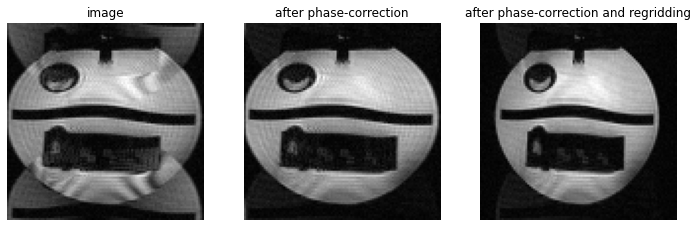

In [8]:
# now activate regridding:
im_array.flags['regrid'] = True
pc_array.flags['regrid'] = True



pc = ifftnd(pc_array[:])

x = np.arange(pc_array.shape[-1]) - pc_array.shape[-1]//2

# calculate phase slope from autocorrelation (for both readout polarities separately - each in its own dim)
slope = np.angle((np.conj(pc[...,1:]) * pc[...,:-1]).sum(-1, keepdims=True))
pc_corr = np.exp(1j * slope * x)

data = im_array[:]
image_pc_regrid = ifftnd(data, [-1])
# apply slope
image_pc_regrid *= pc_corr
image_pc_regrid = image_pc_regrid.sum(5).squeeze()
image_pc_regrid = ifftnd(image_pc_regrid, [0])

image_pc_regrid = rms_comb(image_pc_regrid)


plt.figure(figsize=[12,6])

plt.subplot(131)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')

plt.subplot(132)
plt.title('after phase-correction')
plt.imshow(image_pc, cmap='gray', origin='lower')
plt.axis('off')

plt.subplot(133)
plt.title('after phase-correction and regridding')
plt.imshow(image_pc_regrid, cmap='gray', origin='lower')
plt.axis('off')


# 3) How to modify Mdb data and write it back to a twix file
It is possible to modify data within the `Mdb` object list and then write it back to a twix file using the `write_twix`. Note that `write_twix` is highly experimental. However, in principle it should be possible to take the modified data back to the scanner and then run a retrospective reconstruction using the scanner's reconstruction system. Note that there is currently no tool that helps you to update protocol parameters in case you need to do that to for a successful retrospective reconstruction of the modified data (you can try to modify the `hdr_str` in the twix dict yourself, though, which will then be written to the new twix file together with the mdb data).

## Data manipulation: 
In this simple example, we will read the data from a fully-sampled 2D gradient-echo acquisition, modify the data, and then write it back to a twix file, so that we can bring it back to the scanner for a retrospective reconstruction.

### Reconstructing the data
First let's read the data and map it to a twix_array object:

In [9]:
twix = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'))
mapped = twixtools.map_twix(twix[-1])

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.


\
Now read the image data and reconstruct an image for each coil element:

In [10]:
data = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
image = ifftnd(data, [0,-1]) 

\
Here are images for the two coil elements (body coil with quadrature detection) as well as a rms combination:

(-0.5, 319.5, -0.5, 159.5)

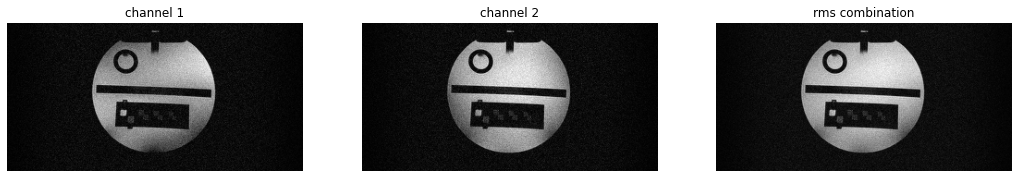

In [11]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('channel 1')
plt.imshow(abs(image[:,0]), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(132)
plt.title('channel 2')
plt.imshow(abs(image[:,1]), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(133)
plt.title('rms combination')
plt.imshow(rms_comb(image, 1), cmap='gray', origin='lower')
plt.axis('off')

\
As you can see, we did not bother to remove the 2x oversampling in read direction, since we want to write back the full data anyway.

### Example I: Deleting data
In this first example, we simply delete every other line from the mdb list using the helper function `del_from_mdb_list`. For this, we need to define a rule in form of a lambda function.

In [12]:
# make sure to start with a fresh 'twix' object
twix_new = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'))

# delete every other line from k-space (2x undersampling)
twixtools.del_from_mdb_list(twix_new[-1]['mdb'], lambda mdb: mdb.is_image_scan() and mdb.cLin % 2)

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.


\
Now we can write the data:

In [13]:
try:
    # in case we have already run this once
    os.remove(os.path.join(example_dir, 'gre_del.dat'))
except:
    pass
twixtools.write_twix(twix_new, os.path.join(example_dir, 'gre_del.dat'))

### Check the results
Let's read in the data from the original & manipulated file and compare the old to the new data:

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.


(-0.5, 159.5, -0.5, 159.5)

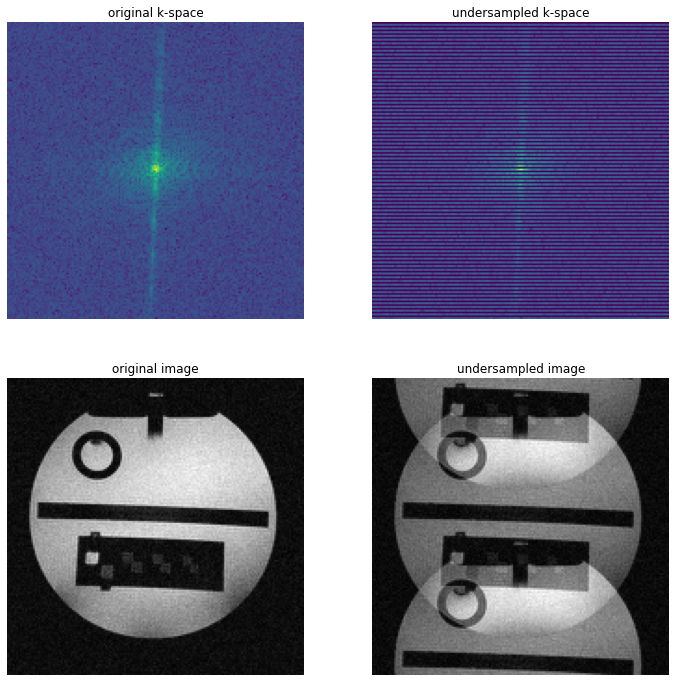

In [14]:






twix_new = twixtools.read_twix(os.path.join(example_dir, 'gre_del.dat'))
mapped_new = twixtools.map_twix(twix_new[-1])
data_new = mapped_new['image'][0,0,0,0,0,0,0,0].squeeze()

# reconstruct images
image_new = ifftnd(data_new, [0, -1])

# simple os-removal by index selection (for better visualization)
ix_k = slice(0, data.shape[-1], 2)
ix_im = slice(data.shape[-1]//4, (data.shape[-1]*3)//4)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('original k-space')
plt.imshow(abs(data[:,0,ix_k])**0.2, origin='lower')
plt.axis('off')
plt.subplot(222)
plt.title('undersampled k-space')
plt.imshow(abs(data_new[:,0,ix_k])**0.2, origin='lower')
plt.axis('off')
plt.subplot(223)
plt.title('original image')
plt.imshow(rms_comb(image[:,:,ix_im], 1), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(224)
plt.title('undersampled image')
plt.imshow(rms_comb(image_new[:,:,ix_im], 1), cmap='gray', origin='lower')
plt.axis('off')

### Example II: Manipulating the data
In this simple example, we just want to invert the image (you may already be familiar with this example).

Let's first find the maximum signal, which then defines the value range for inversion:

In [15]:
max_val = abs(image).max()

\
Now apply the inversion and transform the image back to k-space:

In [16]:
image_inv = max_val-abs(image)

# transform manipulated image back to k-space
data_inv = fftnd(image_inv, [0, -1])

### Writing the Data
`write_twix` expects a list of mdbs (together with the protocol information) as input, so we first need to write our modified data to the original mdb list.

To this end, we first convert each imaging `Mdb` to a `Mdb_local` object, that allows for array manipulation. We then simply loop through the list, and then store the data for the current line counter.

In [17]:
# make sure to start with a fresh 'twix' object
twix_new = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'))

# sort the manipulated data into the mdb list
for key, mdb  in enumerate(twix_new[-1]['mdb']):
    if mdb.is_image_scan():
        mdb = mdb.convert_to_local()
        mdb.data = np.complex64(data_inv[mdb.cLin])
        twix_new[-1]['mdb'][key] = mdb 

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.


\
Now it's time to write the new file!

In [18]:
try:
    # in case we have already run this once
    os.remove(os.path.join(example_dir, 'gre_inv.dat'))
except:
    pass
twixtools.write_twix(twix_new, os.path.join(example_dir, 'gre_inv.dat'))

### Check the results
Let's read in the data from the original & manipulated file and compare the old to the new data:

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.


(-0.5, 159.5, -0.5, 159.5)

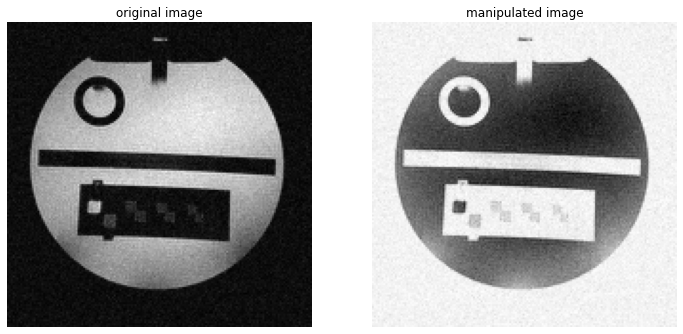

In [19]:
twix_new = twixtools.read_twix(os.path.join(example_dir, 'gre_inv.dat'))
mapped_new = twixtools.map_twix(twix_new[-1])
data_new = mapped_new['image'][0,0,0,0,0,0,0,0].squeeze()
image_new = ifftnd(data_new, [0, -1])

ix_im = slice(data.shape[-1]//4, (data.shape[-1]*3)//4)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('original image')
plt.imshow(rms_comb(image[:,:,ix_im], 1), cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.title('manipulated image')
plt.imshow(rms_comb(image_new[:,:,ix_im], 1), cmap='gray', origin='lower')
plt.axis('off')